**Problem 1**

In this problem, you will learn how to perform linear regression using the matrix method.  The file `Riggs.dat` contains hypothetical particle-physics spectral data (energy vs counts) of a search for a new particle called the *Riggs boson*.  The columns are 1) energy $E$ (GeV) and 2) counts $N$ (number of events in that energy bin).  The energy bins are independent (i.e., there is no covariance).
  
```
   1.0   277
   2.0   254
   3.0   252
   4.0   265
   5.0   266
   6.0   266
   ...
```

  
A signal of a new particle consists of a gaussian on top of a smooth background.  Model the spectrum with a function given by:
$$
  N(E) = a + bE +cE^2 + Ae^{-(E-E_{\mathrm{Riggs}})^2/(2\sigma_E^2)}
$$
where $a,b,c,$ and $A$ are 4 fit parameters.  The first three terms make up the background, the last term represents the signal.  The term $\sigma_E$ represents the intrinsic energy width of the particle and is assumed to be $2.6$ GeV.  Theory also predicts that $E_{\mathrm{Riggs}} = 68.8$ GeV.


a) (4 pts) Given our data and model, construct the design matrix $\mathbf{G}$, data covariance matrix $\mathbf{S}$, and response vector $\mathbf{D}$.

b) (4 pts) Use the matrix operations to solve for the best-fit parameter vector $\hat{\mathbf{A}}$ given by:
$$
\mathbf{\hat{A}} = (\mathbf{G}^T \mathbf{S}^{-1} \mathbf{G)^{-1}} \mathbf{G}^T \mathbf{S}^{-1} \mathbf{D}
$$
and their uncertainties.

c) (2 pts) Plot the data and superimpose the best-fit model.

In [1]:
import numpy as np
import pandas as pd  # You don't need to use this if you don't want.

# Problem 1a
def read_riggs_data(n):
    """
    Read the data file Riggs.dat.
    
    Returns E, N for this run as numpy arrays
    """
    # Hint: If you use pandas to read the file, to_numpy() will convert to a numpy array

    ### BEGIN SOLUTION
    fname = 'Riggs.dat'
    df = pd.read_csv(fname,
                     names=['E', 'N'],  # Give the names of the columns
                     delim_whitespace=True,       # The default is to use ',' as the delimiter. 
                    )
    return df['E'].to_numpy(), df['N'].to_numpy()
    ### END SOLUTION
    
def construct_design_matrix(E, E_Riggs=68.6, sigma_E=2.6):
    """Construct the design matrix for the Riggs boson model.
    
    The columns are [1, E, E^2, exp(-(E-E_Riggs)^2) / 2sigma_E^2]
    
    Each row corresponds to the values of the input E vector.
    
    Returns G, the design matrix.
    """
    ### BEGIN SOLUTION
    G = np.empty((len(E), 4))
    G[:,0] = 1
    G[:,1] = E
    G[:,2] = E**2
    G[:,3] = np.exp(-(E-E_Riggs)**2 / (2*sigma_E**2))
    return G
    ### END SOLUTION
    
def construct_data_covariance_matrix(N):
    """Construct the data vector and the covariance matrix for the given counts.
    
    The counts are taken to be independent with Poisson errors.
    
    Returns D, S, the data vector and its covariance matrix.
    """
    ### BEGIN SOLUTION
    D = N
    S = np.diag(N)
    return D, S
    ### END SOLUTION



In [2]:
E, N = read_riggs_data(0)

print('First few E,N are:')
print(E[0:3])
print(N[0:3])

G = construct_design_matrix(E)
print('Start of design matrix:')
print(G[0:3])

D, S = construct_data_covariance_matrix(N)
print('Start of data vector:')
print(D[0:3])
print('Upper left of covariance matrix:')
print(S[0:3,0:3])

### BEGIN HIDDEN TESTS
# This code snippet lets us just log the test failures so we can see all the things that fail, rather than
# bomb out on the first failure.  Then at the end, we just assert that there were 0 failures to get the
# automatic grading to give points.
nfail=0
from contextlib import contextmanager
import traceback
@contextmanager
def log_assert():
    global nfail
    try:
        yield
    except AssertionError as e:
        print('Failed assert:')
        print(traceback.format_stack()[-3].split('\n')[1])
        print('    msg =',str(e))
        nfail += 1

# Check that E, N are correct
with log_assert():
    assert len(E) == 100, len(E)
with log_assert():
    assert len(N) == 100, len(N)
with log_assert():
    assert np.allclose(E, np.arange(1,101)), E
    
# Check G
with log_assert():
    assert np.all(G[:,0] == 1), G[:,0]
with log_assert():
    np.testing.assert_allclose(G[:,1], E)
with log_assert():
    np.testing.assert_allclose(G[:,2], E**2)
Exx = 68.6
sxx = 2.6
with log_assert():
    np.testing.assert_allclose(G[:,3], np.exp(-(E-Exx)**2 / (2*sxx**2)))
    
# Check D
with log_assert():
    assert np.all(D == N)
with log_assert():
    np.testing.assert_allclose(S, np.diag(N))

print(f"\nTotal of {nfail} test failures")
assert nfail == 0
### END HIDDEN TESTS

First few E,N are:
[1. 2. 3.]
[277 254 252]
Start of design matrix:
[[1.00000000e+000 1.00000000e+000 1.00000000e+000 1.61608841e-147]
 [1.00000000e+000 2.00000000e+000 4.00000000e+000 3.30588364e-143]
 [1.00000000e+000 3.00000000e+000 9.00000000e+000 5.83264122e-139]]
Start of data vector:
[277 254 252]
Upper left of covariance matrix:
[[277   0   0]
 [  0 254   0]
 [  0   0 252]]

Total of 0 test failures


In [3]:
# Problem 1b

def riggs_model(E, params, E_Riggs=68.6, sigma_E=2.6):
    """
    Return the expected counts given the model for the Riggs boson.
    
        N(E) = a + b E + c E**2 + A exp(-(E-E_Riggs)**2/(2 sigma_E**2))
    
    On input, E is an array of energy values.
    And params is [a, b, c, A], an array of the model parameters.
    
    Returns N(E) given the model parameters.
    """
    ### BEGIN SOLUTION
    a,b,c,A = params
    return a + b*E + c*E**2 + A*np.exp(-(E-E_Riggs)**2 / (2*sigma_E**2))
    ### END SOLUTION
    
    
def fit_riggs_model(E, N, E_Riggs=68.6, sigma_E=2.6):
    """
    Find the best fit model given the observed data N(E)

    Returns the parameters [a, b, c, A] as a numpy array 
    and the covariance matrix, also as a numpy array.
    """
    # Hints:
    # 1. Use the above equations to get the D vector and G, S matrices.
    # 2. Compute A =(G^T S^−1 G)^−1 G^T S^−1 D using numpy functions
    
    ### BEGIN SOLUTION
    G = construct_design_matrix(E)
    D, S = construct_data_covariance_matrix(N)
    
    Sinv = np.linalg.inv(S)
    
    # A = (G^T S^-1 G)^-1 (G^T S^-1 D)
    # Cov(A) = (G^T S^-1 G)^-1
    CovA = np.linalg.inv(G.T.dot(Sinv).dot(G))
    A = CovA.dot(G.T).dot(Sinv).dot(D)
    
    return A, CovA
    ### END SOLUTION

In [4]:
params, cov = fit_riggs_model(E, N)

print('params = ',params)
print('cov = ',cov)

fitted_model = riggs_model(E, params)
print('First few fitten N values:')
print(fitted_model[0:3])

### BEGIN HIDDEN TESTS
nfail = 0

# Try a few different params, not just the fitted model.
a,b,c,A = params
with log_assert():
    np.testing.assert_allclose(fitted_model, a + b*E + c*E**2 + A*np.exp(-(E-Exx)**2 / (2*sxx**2)))
    
p = np.array([200, 0.2, 0.1, 120])
a,b,c,A = p
model = riggs_model(E, p)
with log_assert():
    np.testing.assert_allclose(model, a + b*E + c*E**2 + A*np.exp(-(E-Exx)**2 / (2*sxx**2)))

p = np.array([100, 1.2, 4.1, -1020])
a,b,c,A = p
model = riggs_model(E, p)
with log_assert():
    np.testing.assert_allclose(model, a + b*E + c*E**2 + A*np.exp(-(E-Exx)**2 / (2*sxx**2)))
    
# Check that the fit is correct
Gxx = construct_design_matrix(E)
Dxx = N
Sinvxx = np.diag(1./N)
CovAxx = np.linalg.inv(Gxx.T.dot(Sinvxx).dot(Gxx))
Axx = CovAxx.dot(Gxx.T).dot(Sinvxx).dot(Dxx)
with log_assert():
    np.testing.assert_allclose(params, Axx)
with log_assert():
    np.testing.assert_allclose(cov, CovAxx)
    
print(f"\nTotal of {nfail} test failures")
assert nfail == 0
### END HIDDEN TESTS

params =  [2.66472053e+02 2.43049676e-01 1.01602227e-01 1.20201807e+02]
cov =  [[ 3.06449981e+01 -1.42574009e+00  1.28226492e-02  9.73056134e+00]
 [-1.42574009e+00  9.07535491e-02 -9.19376830e-04 -6.77774365e-01]
 [ 1.28226492e-02 -9.19376830e-04  1.01662084e-05  3.44527830e-03]
 [ 9.73056134e+00 -6.77774365e-01  3.44527830e-03  2.15458952e+02]]
First few fitten N values:
[266.81670484 267.36456119 268.115622  ]

Total of 0 test failures


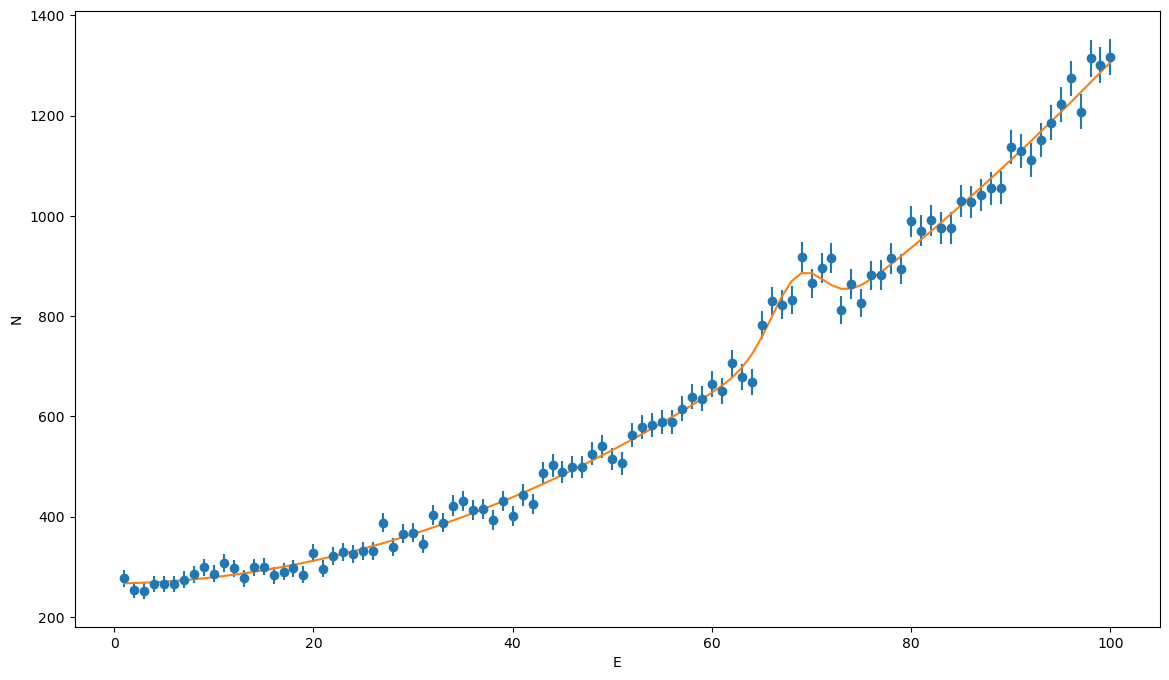

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### BEGIN SOLUTION
fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.errorbar(E, N, np.sqrt(N), fmt='o')
ax.plot(E,riggs_model(E,params))
ax.set_xlabel('E')
ax.set_ylabel('N')
plt.show()
### END SOLUTION

---

**Bonus Problem**

A nice way to visualize the covariance matrix of a fit is to sample values of the parameters that would be consistent with the errors.

1. First take the Cholesky decomposition of the covariance matrix: $L L^{T} = \mathrm{Cov}(\hat A)$
 
2. Then make a vector of 4 zero-mean, unit-variance Gaussian random values: 
$v = [X_0, X_1, X_2, X_3]^T; \quad X_i \leftarrow \cal{N}(0,1)$

3. Multiply them together using matrix math: $\delta \hat{\mathbf{A}} = L v$

This gives you random deviations from the fitted parameter values $\hat{\mathbf{A}}$ according to the appropriate statistics given by the covariance matrix.  You can now plot a bunch of models with parameters $\hat{\mathbf{A}} + \delta \hat{\mathbf{A}}$ to see the range of possible solutions that are plausible given the errors.  Doing this with a small line width (lw) and making them semi-transparent (alpha < 1) provides a nice visualization of the set of possible lines.

[[ 3.06449981e+01 -1.42574009e+00  1.28226492e-02  9.73056134e+00]
 [-1.42574009e+00  9.07535491e-02 -9.19376830e-04 -6.77774365e-01]
 [ 1.28226492e-02 -9.19376830e-04  1.01662084e-05  3.44527830e-03]
 [ 9.73056134e+00 -6.77774365e-01  3.44527830e-03  2.15458952e+02]]
[[ 5.53579245e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.57549412e-01  1.56274917e-01  0.00000000e+00  0.00000000e+00]
 [ 2.31631683e-03 -2.06565967e-03  7.30708469e-04  0.00000000e+00]
 [ 1.75775400e+00 -1.44019181e+00 -4.92834445e+00  1.36384208e+01]]


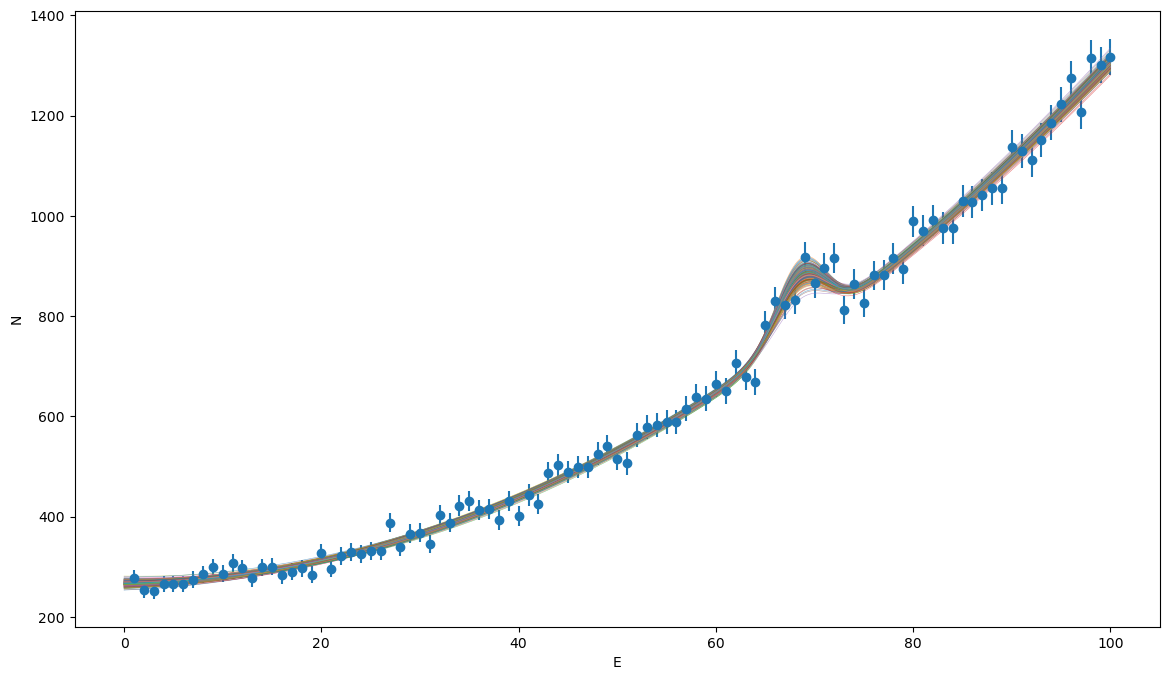

In [16]:
# Hints: Use np.linalg.cholesky to get L of the Cholesky decomposition.
#        np.random.randn(4) will return a 4-element Gaussian random deviate
#        Run a bunch of these shifted parameters.  Say 200 or so.
#        Experiment with different values of lw and alpha in the plot command to make it look nice.

### BEGIN SOLUTION
# Draw the data the same way as before.
fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.errorbar(E, N, np.sqrt(N), fmt='o')
ax.set_xlabel('E')
ax.set_ylabel('N')

print(cov)
L = np.linalg.cholesky(cov)
print(L)
Econt = np.linspace(0, 100, 1000)
for i in range(200):
    # Sample a,b values randomly given the covariance matrix.
#    v = np.random.randn(4)
#    dparams = L.dot(v)
#    ax.plot(E,riggs_model(E,params + dparams), color='magenta', lw=0.1, alpha=0.2)
    u = (np.random.randn(4))
    deltaA = np.dot (L, u)
    Adelt = params + deltaA
    deviations = riggs_model(Econt, Adelt)
    plt.plot (Econt, deviations, alpha=0.6, linewidth=0.4)
plt.show()
### END SOLUTION

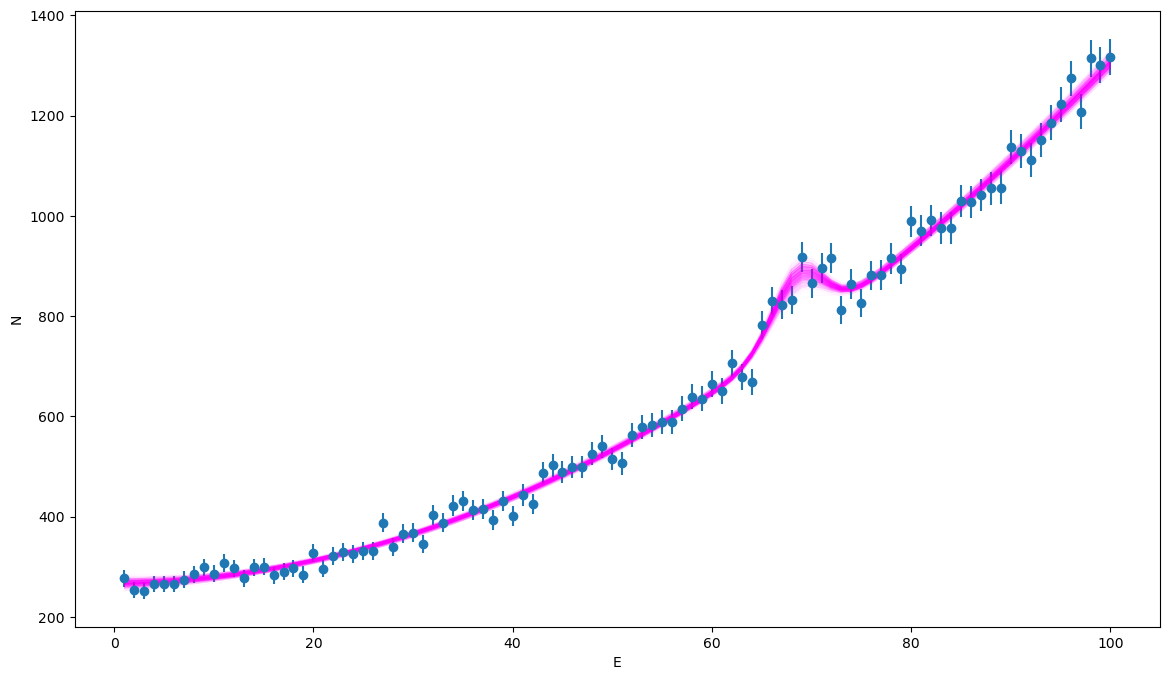

In [7]:
# Hints: Use np.linalg.cholesky to get L of the Cholesky decomposition.
#        np.random.randn(4) will return a 4-element Gaussian random deviate
#        Run a bunch of these shifted parameters.  Say 200 or so.
#        Experiment with different values of lw and alpha in the plot command to make it look nice.

### BEGIN SOLUTION
# Draw the data the same way as before.
fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.errorbar(E, N, np.sqrt(N), fmt='o')
ax.set_xlabel('E')
ax.set_ylabel('N')

L = np.linalg.cholesky(cov)
for i in range(500):
    # Sample a,b values randomly given the covariance matrix.
    ranparams = np.random.default_rng().multivariate_normal(params, cov)
    ax.plot(E,riggs_model(E,ranparams), color='magenta', lw=0.1, alpha=0.2)
plt.show()
### END SOLUTION